In [2]:
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import yaml
from torch.nn.parallel import DistributedDataParallel as DDP
import sys, os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms as transforms
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import Dataset
import torch.optim as optim
# root_dir = '/mnt/home/spandey/ceph/CHARM/'
# os.chdir(root_dir)
import pickle as pk
import pathlib
curr_path = pathlib.Path().absolute()
src_path = os.path.abspath(curr_path / "../../charm/") 
sys.path.append(src_path)
# sys.path.append(root_dir)
# from combined_models import *
# from all_models import *
from charm import *
from utils_data_prep_cosmo_vel import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
from colossus.lss import mass_function
from tqdm import tqdm
import sparse
import numpy as np
import h5py as h5
import torch
from torch.nn import functional as F
from dataclasses import dataclass
from contextlib import nullcontext
from dataclasses import dataclass
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pyplot as pl

import os
%load_ext autoreload
%autoreload 2
%matplotlib inline




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# test_id = 3

saved_all_test = {}
test_id_all = np.arange(1800, 1820)




In [44]:
for test_id in test_id_all:
    print(test_id)
    saved_all_test[test_id] = {}
    # run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128.yaml'
    run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128_lresdata.yaml'
    with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
        config=yaml.load(file_object,Loader=yaml.SafeLoader)


    config_sims = config['sim_settings']
    ji_array = np.arange(int(config_sims['nsims']))
    nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
    nsubvol_fid = int(config_sims['nsubvol_fid'])
    subsel_criteria = config_sims['subsel_criteria']
    num_cosmo_params = int(config_sims['num_cosmo_params'])
    ns_d = config_sims['ns_d']
    nb = config_sims['nb']
    nax_d =  ns_d // nb
    nf = config_sims['nf']
    layers_types = config_sims['layers_types']
    z_inference = config_sims['z_inference']
    nc = 0
    for jl in range(len(layers_types)):
        if layers_types[jl] == 'cnn':
            nc += 1
        elif layers_types[jl] == 'res':
            nc += 2
        else:
            raise ValueError("layer type not supported")

    z_all = config_sims['z_all']
    z_all_FP = config_sims['z_all_FP']
    # z_all_FP = z_all_FP[:-1]
    z_all_FP = z_all_FP
    ns_h = config_sims['ns_h']
    nax_h = ns_h // nb
    cond_sim = config_sims['cond_sim']

    nsims_per_batch = config_sims['nsims_per_batch']
    nbatches_train = config_sims['nbatches_train']

    mass_type = config_sims['mass_type']
    lgMmin = config_sims['lgMmin']
    lgMmax = config_sims['lgMmax']
    stype = config_sims['stype']
    rescale_sub = config_sims['rescale_sub']
    lgMmincutstr = config_sims['lgMmincutstr']
    # subsel_highM1 = config_sims['subsel_highM1']
    # nsubsel = config_sims['nsubsel']
    is_HR = config_sims['is_HR']

    try:
        Nmax = config_sims['Nmax']
    except:
        Nmax = 4

    config_net = config['network_settings']
    hidden_dim_MAF = config_net['hidden_dim_MAF']
    learning_rate = config_net['learning_rate']
    K_M1 = config_net['K_M1']
    B_M1 = config_net['B_M1']
    nflows_M1_NSF = config_net['nflows_M1_NSF']

    K_Mdiff = config_net['K_Mdiff']
    B_Mdiff = config_net['B_Mdiff']
    nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

    base_dist_Ntot = config_net['base_dist_Ntot']
    if base_dist_Ntot == 'None':
        base_dist_Ntot = None
    base_dist_M1 = config_net['base_dist_M1']
    base_dist_Mdiff = config_net['base_dist_Mdiff']
    ngauss_M1 = config_net['ngauss_M1']

    changelr = config_net['changelr']
    ksize = nf
    nfeature_cnn = config_net['nfeature_cnn']
    nout_cnn = 4 * nfeature_cnn
    if cond_sim == 'fastpm':
        if any('v' in str(string) for string in z_all_FP):
            ninp = len(z_all_FP) + 2
        else:
            ninp = len(z_all_FP)

    elif cond_sim == 'quijote':
        ninp = len(z_all)
    else:
        raise ValueError("cond_sim not supported")

    num_cond = nout_cnn + ninp + num_cosmo_params


    device_id = torch.device("cuda")
    ndim_diff = Nmax - 1

    lgM_array = np.linspace(lgMmin, lgMmax, 1000)
    M_array = 10**lgM_array
    if '200c' in mass_type:
        hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
    if 'vir' in mass_type:
        hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
    if 'fof' in mass_type:
        hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
    lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

    int_val = sp.integrate.simps(hmf, lgM_rescaled)
    hmf_pdf = hmf/int_val
    # define the cdf of the halo mass function
    hmf_cdf = np.zeros_like(hmf_pdf)
    for i in range(len(hmf_cdf)):
        hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])

    if 'sigv' in config:
        sigv = config['sigv']
    else:
        sigv = 0.05
    num_cond_Ntot = num_cond
    mu_all = np.arange(Nmax + 1) + 1
    sig_all = sigv * np.ones_like(mu_all)
    ngauss_Nhalo = Nmax + 1

    model_BinaryMask = SumGaussModel(
        hidden_dim=hidden_dim_MAF,
        num_cond=num_cond_Ntot,
        ngauss=2,
        mu_all=mu_all[:2],
        sig_all=sig_all[:2],
        base_dist=base_dist_Ntot,
        device=device_id
        )

    # model_BinaryMask.to(dev)


    model_multiclass = SumGaussModel(
        hidden_dim=hidden_dim_MAF,
        num_cond=num_cond_Ntot,
        ngauss=ngauss_Nhalo - 1,
        mu_all=mu_all[1:] - 1,
        sig_all=sig_all[1:],
        base_dist=base_dist_Ntot,
        device=device_id
        )


    # model_multiclass.to(dev)


    num_cond_M1 = num_cond + 1
    # # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
    # if cond_sim == 'fastpm':
    #     num_cond_M1 += 2

    model_M1 = NSF_1var_CNNcond(
        K=K_M1,
        B=B_M1,
        hidden_dim=hidden_dim_MAF,
        num_cond=num_cond_M1,
        nflows=nflows_M1_NSF,
        base_dist=base_dist_M1,
        ngauss=ngauss_M1,
        lgM_rs_tointerp=lgM_rescaled,
        hmf_pdf_tointerp=hmf_pdf,
        hmf_cdf_tointerp=hmf_cdf,
        device=device_id 
        )

    ndim_diff = Nmax - 1
    num_cond_Mdiff = num_cond + 2
    model_Mdiff = NSF_Autoreg_CNNcond(
        dim=ndim_diff,
        K=K_Mdiff,
        B=B_Mdiff,
        hidden_dim=hidden_dim_MAF,
        num_cond=num_cond_Mdiff,
        nflows=nflows_Mdiff_NSF,
        base_dist=base_dist_Mdiff,
        mu_pos=True
        )


    ndim = ndim_diff + 1
    model = COMBINED_Model(
        None,
        model_Mdiff,
        # None,
        model_M1,
        model_BinaryMask,
        model_multiclass,
        ndim,
        ksize,
        ns_d,
        ns_h,
        1,
        ninp,
        nfeature_cnn,
        nout_cnn,
        layers_types=layers_types,
        act='tanh',
        padding='valid',
        sep_Binary_cond=True,
        sep_MultiClass_cond=True,
        sep_M1_cond=True,
        sep_Mdiff_cond=True,
        num_cond_Binary = num_cond_Ntot,
        num_cond_MultiClass = num_cond_Ntot,
        num_cond_M1 = num_cond_M1,
        num_cond_Mdiff = num_cond_Mdiff
        ).to(device_id)

    # model = DDP(model, device_ids=[device_id], find_unused_parameters=True)

    model = torch.nn.DataParallel(model)


    ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test0/'

    checkpoint = torch.load(ldir_cp + f'test_model_bestfit_6484.pth', map_location=device_id)
    # print(iter)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    print()



    ldir_f = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'

    n_dim_red = (nf - 1) // 2
    n_pad = n_dim_red * nc

    df_zg = pk.load(open(ldir_f + '%d/density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk'%test_id,'rb'))
    df_test_zg = df_zg['density_cic_unpad_combined']
    df_test_pad_zg = np.pad(df_test_zg, n_pad, 'wrap')



    z_REDSHIFT = float(z_all_FP[-1].split('_')[1])
    if z_REDSHIFT == 0.0:
        z_REDSHIFT = 0

    df_load = pk.load(open(
        ldir_f + '/' + str(test_id) + '/velocity_HR_full_m_res_128_z=' + str(z_REDSHIFT) + '_nbatch_8_nfilter_3_ncnn_0.pk', 'rb')
        )

    vel_all = df_load['velocity_cic_unpad_combined']
    # # vel_pad_all = 
    vel_pad = np.stack([np.pad(vel_all[j,...], n_pad, 'wrap') for j in range(3)], axis=0)

    df_test_all_pad = np.concatenate([np.log(1 + df_test_pad_zg + 1e-10)[None,...], vel_pad], axis=0)[None, None,:]
    # df_test_all_pad = np.stack([np.log(1 + df_test_pad_zg + 1e-10), np.log(
    #     1 + df_test_pad_zIC + 1e-10), df_test_pad_constrast_zg], axis=0)[None, None, :]

    # df_test_all_pad.shape

    # density_smoothed = gaussian_filter(df_test_zg, sigma=VALUE_SIG)
    # df_test_constrast_zg = density_smoothed - df_test_zg
    # 
    df_test_all_unpad = np.concatenate([np.log(1 + df_test_zg + 1e-10)[None,...], vel_all], axis=0)[None, None,:]
    # df_test_all_unpad = np.stack([np.log(1 + df_test_zg + 1e-10), np.log(
    #     1 + df_test_zIC + 1e-10), df_test_constrast_zg], axis=0)[None, None, :]

    # df_test_all_unpad.shape

    cond_nsh_test = np.moveaxis(df_test_all_unpad, 2, 5)
    nsims_test = cond_nsh_test.shape[1]
    nax_h_test = cond_nsh_test.shape[2]
    ninp_test = cond_nsh_test.shape[-1]
    cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h_test ** 3), ninp_test))).cuda(device_id)    

    # cond_tensor_nsh_test.shape
    LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
    LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
    fid_cosmo_val_all = LH_cosmo_val_all[test_id]
    # fid_cosmo_val_all = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.64])  

    cosmo_val_test = np.tile(fid_cosmo_val_all, (cond_tensor_nsh_test.shape[1] ,1))[None,:]

    # cosmo_val_test.shape
    # df_test_all_pad.shape, df_test_all_unpad.shape, cosmo_val_test.shape
    df_test_all_pad = torch.tensor(df_test_all_pad).to(device_id)
    df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)
    cosmo_val_test = torch.tensor(cosmo_val_test, dtype=torch.float32).to(device_id)


    train_Ntot, train_M1, train_Mdiff = 1, 1, 1
    train_binary, train_multi = 1, 1
    # if verbose:
        # print(f"Running the model")

    # run the model
    Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, _ = model.module.inverse(
        cond_x=df_test_all_pad,
        cond_x_nsh=df_test_all_unpad,
        cond_cosmo=cosmo_val_test,
        use_truth_Nhalo=1-train_Ntot,
        use_truth_M1=1-train_M1,
        use_truth_Mdiff=1-train_Mdiff,
        mask_Mdiff_truth=None,
        mask_M1_truth=None,
        Nhalos_truth=None,
        M1_truth=None,
        Mdiff_truth=None,
        train_binary=train_binary,
        train_multi=train_multi,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff,
    )


    BoxSize=1000
    # Ntot_samp_test[0].shape
    Ntot_samp_test_rs = Ntot_samp_test[0][:, np.newaxis]
    M1_samp_test_rs = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]).cpu().detach().numpy()
    M_diff_samp_test_rs = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]).cpu().detach().numpy()




    Ntot_samp_test = Ntot_samp_test[0][:, np.newaxis]
    save_subvol_Nhalo = Ntot_samp_test.reshape(
        nsims_test, nax_h_test, nax_h_test, nax_h_test)
    save_subvol_M1 = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]
                        ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, 1)
    save_subvol_Mdiff = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)

    mask_subvol_Mtot1 = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(
        nsims_test, nax_h_test, nax_h_test, nax_h_test)[..., None]
    mask_subvol_Mtot2 = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy(
    ).reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)
    mask_subvol_Mtot = np.concatenate(
        [mask_subvol_Mtot1, mask_subvol_Mtot2], axis=-1)

    # compute the mass of halos from output
    save_subvol_Mtot = np.zeros(
        (nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff + 1))
    # Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (
                save_subvol_M1[..., 0] + 0.5) * (lgMmax - lgMmin) + lgMmin
        else:
            save_subvol_Mtot[...,
                                jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (lgMmax - lgMmin)

    save_subvol_Mtot *= mask_subvol_Mtot

    Mhalos_mock = save_subvol_Mtot[0, ...]
    Nhalos_mock = save_subvol_Nhalo[0, ...]


    dfname_truth = f'/mnt/ceph/users/spandey/Quijote/data_NGP_self_LH/{test_id}/SPARSEMATS_halos_HR_rockstar_200c_lgMmincut_5e12_full_res_128_z=0.5.pk' 
    df_h = pk.load(open(dfname_truth, 'rb'))
    M_halos_truth = df_h['M_halos_combined'].todense()[...,:Nmax]
    Nhalos_truth = df_h['N_halos_combined'].todense()


    saved_all_test[test_id]['Nhalos_truth'] = Nhalos_truth
    saved_all_test[test_id]['Mhalos_truth'] = M_halos_truth
    saved_all_test[test_id]['Nhalos_mock'] = Nhalos_mock
    saved_all_test[test_id]['Mhalos_mock'] = Mhalos_mock

    saved_all_test[test_id]['cosmology'] = fid_cosmo_val_all


1800


/tmp/ipykernel_1033012/2260271870.py:106: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_1033012/2260271870.py:111: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


/tmp/ipykernel_1033012/2260271870.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)


1801

1802

1803

1804

1805

1806

1807

1808

1809

1810

1811

1812

1813

1814

1815

1816

1817

1818

1819



In [29]:
import matplotlib
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline
import yaml


# autoreload modules
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
Om_all = []
for ji, isim in enumerate(test_id_all):
    Om_all.append(saved_all_test[isim]['cosmology'][0])
    # print(saved_all_test[isim]['cosmology'][0])
Om_all = np.array(Om_all)
# test_id_all[0,1,2,3,7]

# test_id_all[indsel]
    

In [56]:
argsort_Om = np.argsort(Om_all)
# Om_all[argsort_Om]
indsel = argsort_Om[[0,3,6,11,15]]


In [57]:
# indsel
Om_all[argsort_Om]

array([0.1357, 0.1687, 0.1701, 0.2155, 0.2349, 0.2873, 0.2945, 0.3167,
       0.3265, 0.3545, 0.3717, 0.3887, 0.3901, 0.4011, 0.4081, 0.4503,
       0.4811, 0.4855, 0.4861, 0.4947])

0.13570000000000002
0.2155
0.2945
0.38870000000000005
0.45030000000000003


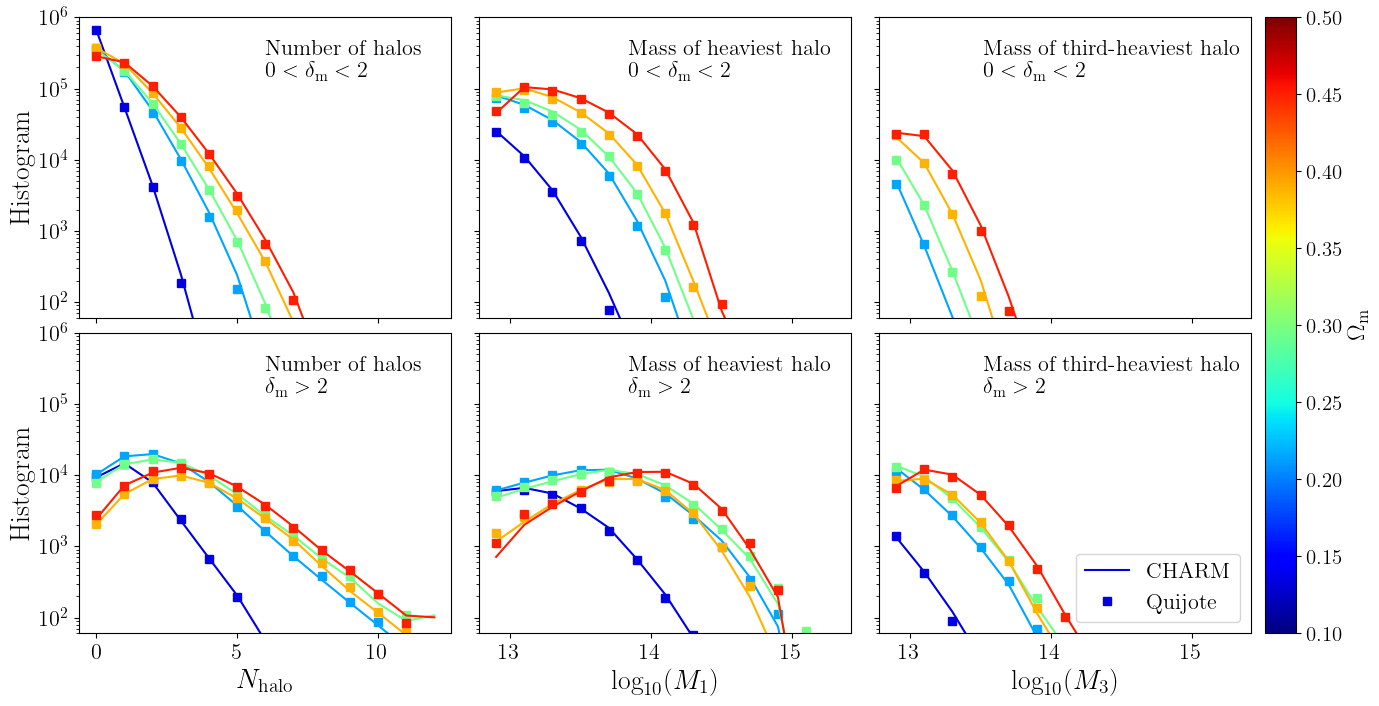

In [59]:
from matplotlib import cm

#normalize item number values to colormap
# norm = matplotlib.colors.Normalize(vmin=0.6, vmax=1.0)
norm = matplotlib.colors.Normalize(vmin=0.1, vmax=0.5)

fig, axes = pl.subplots(2, 3, figsize=(18, 8), sharey=True, sharex='col')
# reduce the spacing between panels:
pl.subplots_adjust(wspace=0.075, hspace=0.05)
bin_cents = np.array(np.arange(Nmax + 1))
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
bin_edges = np.insert(bin_edges,0, -0.5)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)

bin_cents_M = np.linspace(12.7, 15.5, 15)[1:-1]
bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] + delta_b)

# indsel = np.array([0,1,2,3,6])
sdir_cosmo = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'
for ji, isim in enumerate(test_id_all[indsel]):
    # delta_df = saved_all_test[isim]['delta_all_z0']
    delta_df = pk.load(open(sdir_cosmo + str(isim) + '/density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk', 'rb'))['density_cic_unpad_combined']        
    indsel_1 = np.where((delta_df > 0) & (delta_df < 2))
    indsel_2 = np.where((delta_df > 2))

    Nhalos_truth = saved_all_test[isim]['Nhalos_truth']
    Nhalos_mock = saved_all_test[isim]['Nhalos_mock']

    Mhalos_truth0 = saved_all_test[isim]['Mhalos_truth'][...,0]
    Mhalos_mock0 = saved_all_test[isim]['Mhalos_mock'][...,0]

    Mhalos_truth2 = saved_all_test[isim]['Mhalos_truth'][...,2]
    Mhalos_mock2 = saved_all_test[isim]['Mhalos_mock'][...,2]


    cosmo = saved_all_test[isim]['cosmology']
    print(cosmo[0])
    # sigma8_ji = cosmo[-1]
    # color_ji = cm.jet(norm(sigma8_ji)) 

    Om_ji = cosmo[0]
    color_ji = cm.jet(norm(Om_ji)) 


    # hist_truth_all, _ = np.histogram(Nhalos_truth.flatten(), bins=bin_edges)
    # hist_samp_all, _ = np.histogram(Nhalos_mock.flatten(), bins=bin_edges)

    hist_truth_low, _ = np.histogram(Nhalos_truth[indsel_1].flatten(), bins=bin_edges)
    hist_samp_low, _ = np.histogram(Nhalos_mock[indsel_1].flatten(), bins=bin_edges)

    hist_truth_high, _ = np.histogram(Nhalos_truth[indsel_2].flatten(), bins=bin_edges)
    hist_samp_high, _ = np.histogram(Nhalos_mock[indsel_2].flatten(), bins=bin_edges)

    axes[0,0].plot(bin_cents, hist_samp_low, ls='-', color=color_ji)    
    axes[0,0].plot(bin_cents, hist_truth_low, ls='', marker='s', color=color_ji)    
    axes[0,0].set_yscale('log')
    axes[0,0].set_ylim(60, 1e6)
    axes[0,0].set_ylabel(r'Histogram', size=20)
    if ji == 0:
        label = 'Number of halos' + '\n' + r'$0 < \delta_{\rm m} < 2$'
        axes[0,0].text(0.5, 0.8, label, transform=axes[0,0].transAxes, fontsize=16)



    axes[1,0].plot(bin_cents, hist_samp_high, ls='-', color=color_ji)    
    axes[1,0].plot(bin_cents, hist_truth_high, ls='', marker='s',  color=color_ji)    
    axes[1,0].set_yscale('log')
    axes[1,0].set_xlabel(r'$N_{\rm halo}$', size=20)
    axes[1,0].set_ylabel(r'Histogram', size=20)
    if ji == 0:
        label = 'Number of halos' + '\n' + r'$\delta_{\rm m} > 2$'
        axes[1,0].text(0.5, 0.8, label, transform=axes[1,0].transAxes, fontsize=16)


    hist_truth_low, _ = np.histogram(Mhalos_truth0[indsel_1].flatten(), bins=bin_edges_M)
    hist_samp_low, _ = np.histogram(Mhalos_mock0[indsel_1].flatten(), bins=bin_edges_M)

    hist_truth_high, _ = np.histogram(Mhalos_truth0[indsel_2].flatten(), bins=bin_edges_M)
    hist_samp_high, _ = np.histogram(Mhalos_mock0[indsel_2].flatten(), bins=bin_edges_M)

    axes[0,1].plot(bin_cents_M, hist_samp_low, ls='-', color=color_ji)    
    axes[0,1].plot(bin_cents_M, hist_truth_low, ls='', marker='s', color=color_ji)    
    axes[0,1].set_yscale('log')
    if ji == 0:
        label = r'Mass of heaviest halo' + '\n' + r'$0 < \delta_{\rm m} < 2$'
        axes[0,1].text(0.4, 0.8, label, transform=axes[0,1].transAxes, fontsize=16)


    axes[1,1].plot(bin_cents_M, hist_samp_high, ls='-', color=color_ji)    
    axes[1,1].plot(bin_cents_M, hist_truth_high, ls='', marker='s',  color=color_ji)    
    axes[1,1].set_yscale('log')
    axes[1,1].set_xlabel(r'$\log_{10}(M_1)$', size=20)    

    if ji == 0:
        label = r'Mass of heaviest halo' + '\n' + r'$\delta_{\rm m} > 2$'
        axes[1,1].text(0.4, 0.8, label, transform=axes[1,1].transAxes, fontsize=16)


    hist_truth_low, _ = np.histogram(Mhalos_truth2[indsel_1].flatten(), bins=bin_edges_M)
    hist_samp_low, _ = np.histogram(Mhalos_mock2[indsel_1].flatten(), bins=bin_edges_M)

    hist_truth_high, _ = np.histogram(Mhalos_truth2[indsel_2].flatten(), bins=bin_edges_M)
    hist_samp_high, _ = np.histogram(Mhalos_mock2[indsel_2].flatten(), bins=bin_edges_M)

    axes[0,2].plot(bin_cents_M, hist_samp_low, ls='-', color=color_ji)    
    axes[0,2].plot(bin_cents_M, hist_truth_low, ls='', marker='s', color=color_ji)    
    axes[0,2].set_yscale('log')
    if ji == 0:
        label = r'Mass of third-heaviest halo' + '\n' + r'$0 < \delta_{\rm m} < 2$'
        axes[0,2].text(0.28, 0.8, label, transform=axes[0,2].transAxes, fontsize=16)

    if ji == 0:
        axes[1,2].plot(bin_cents_M, hist_samp_high, ls='-', color=color_ji, label='CHARM')    
        axes[1,2].plot(bin_cents_M, hist_truth_high, ls='', marker='s',  color=color_ji, label='Quijote')    
    else:
        axes[1,2].plot(bin_cents_M, hist_samp_high, ls='-', color=color_ji)    
        axes[1,2].plot(bin_cents_M, hist_truth_high, ls='', marker='s',  color=color_ji)    
    axes[1,2].legend(fontsize=16, loc='lower right')
    axes[1,2].set_yscale('log')
    axes[1,2].set_xlabel(r'$\log_{10}(M_3)$', size=20)    
    if ji == 0:
        label = r'Mass of third-heaviest halo' + '\n' + r'$\delta_{\rm m} > 2$'
        axes[1,2].text(0.28, 0.8, label, transform=axes[1,2].transAxes, fontsize=16)
      
# pl.yscale('log')
for i in range(2):
    for j in range(3):
        axes[i,j].tick_params(axis='both', which='major', labelsize=16)
        axes[i,j].tick_params(axis='both', which='minor', labelsize=16)


cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=axes, label=r'$\sigma_8$', pad=0.01)
# set labelsize and colorbar location:
# cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
# cbar.set_label(r'$\sigma_8$', size=18)
cbar.set_label(r'$\Omega_{\rm m}$', size=18)
# cbar.set_ticks(np.arange(0.6, 1.01, 0.1))

fig.savefig('/mnt/home/spandey/ceph/CHARM/results/paper_plots/1pt_stat_pred.pdf', bbox_inches='tight')




In [13]:
indsel_mock = np.where(Nhalos_mock > 0)
indsel_truth = np.where(Nhalos_truth > 0)
bin_cents = np.array(np.arange(Nmax + 1))
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
bin_edges = np.insert(bin_edges,0, -0.5)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)

Nhalos_mock_sel = Nhalos_mock[indsel_mock]
Nhalos_truth_sel = Nhalos_truth[indsel_truth]

# pl.figure()
# pl.hist(, bins=100, alpha=0.5, label='mock')


((128, 128, 128, 20), (128, 128, 128))

In [ ]:
pl.figure()
pl.hist(Ntot_samp_test_rs, bins=100)


